##### Task 3: Forecast Future Market Trends (TSLA)
Use the trained model from Task 2 (ARIMA/SARIMA/LSTM) to generate 6–12 month forecasts, visualize with confidence intervals, and interpret trends and risks.

In [42]:
# Ensure project root is on sys.path so `src` and `models` imports work
import os
import sys

def _find_project_root(start_path):
    current = os.path.abspath(start_path)
    while True:
        has_src = os.path.isdir(os.path.join(current, "src"))
        has_models = os.path.isdir(os.path.join(current, "models"))
        has_pyproject = os.path.isfile(os.path.join(current, "pyproject.toml"))
        has_setup = os.path.isfile(os.path.join(current, "setup.py"))
        if (has_src and has_models) or has_pyproject or has_setup:
            return current
        parent = os.path.dirname(current)
        if parent == current:
            # If we reach the root and haven't found the project root, raise a clear error about missing dependencies
            raise ModuleNotFoundError(
                "Could not find the project root containing 'src' and 'models' directories. "
                "This may be due to missing dependencies such as the 'arch' package required by 'src/financial_analysis.py'.\n"
                "To fix this error, please install the missing package(s), e.g.:\n"
                "    pip install arch\n"
                "Or comment/remove the import of 'AdvancedFinancialAnalysis' in 'src/__init__.py' if not needed."
            )
        current = parent

_project_root = _find_project_root(os.getcwd())
if _project_root and _project_root not in sys.path:
    sys.path.insert(0, _project_root)

In [43]:
import warnings
warnings.filterwarnings('ignore')

# Suppress prophet plotly warning
import logging
logging.getLogger('prophet.plot').setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data_manager import DataManager
from models.forecasting_models import ARIMAForecaster, SARIMAForecaster, LSTMForecaster
from src.model_selection import chronological_split, arima_order_grid_search
from src.forecasting_analysis import ForecastAnalyzer

# Patch: If 'arch' is not installed, monkeypatch AdvancedFinancialAnalysis to avoid import error
try:
    try:
        from src.financial_analysis import AdvancedFinancialAnalysis
    except ModuleNotFoundError as e:
        if "sklearn" in str(e):
            import types
            class AdvancedFinancialAnalysis:
                def __init__(self, *args, **kwargs):
                    raise ImportError("AdvancedFinancialAnalysis requires the 'sklearn' package. Please install it to use this feature.")
            import sys
            sys.modules['src.financial_analysis'] = types.SimpleNamespace(AdvancedFinancialAnalysis=AdvancedFinancialAnalysis)
        else:
            raise
except ModuleNotFoundError as e:
    import types
    import sys
    # Patch for missing 'arch' (for AdvancedFinancialAnalysis)
    if "arch" in str(e):
        class AdvancedFinancialAnalysis:
            def __init__(self, *args, **kwargs):
                raise ImportError("AdvancedFinancialAnalysis requires the 'arch' package. Please install it to use this feature.")
        sys.modules['src.financial_analysis'] = types.SimpleNamespace(AdvancedFinancialAnalysis=AdvancedFinancialAnalysis)
    # Patch for missing 'sklearn' (for forecasting_models)
    elif "sklearn" in str(e):
        # Patch models.forecasting_models and its symbols to raise on use
        class _MissingSklearnForecaster:
            def __init__(self, *args, **kwargs):
                raise ImportError("This forecasting model requires the 'sklearn' package. Please install it to use this feature.")
        # Patch the module and its symbols
        fake_mod = types.SimpleNamespace(
            ARIMAForecaster=_MissingSklearnForecaster,
            SARIMAForecaster=_MissingSklearnForecaster,
            LSTMForecaster=_MissingSklearnForecaster,
        )
        sys.modules['models.forecasting_models'] = fake_mod
        sys.modules['models'] = types.SimpleNamespace(forecasting_models=fake_mod)
    else:
        # Patch for missing plotly for Prophet plots: warn but do not raise
        import logging
        logging.getLogger("prophet.plot").warning(
            "Importing plotly failed. Interactive plots will not work."
        )
plt.style.use('seaborn-v0_8')
%matplotlib inline


##### 1) Load TSLA and refit a model from Task 2 (if needed)

For reproducibility, we reselect an ARIMA order via a quick grid search and fit on the full history.


In [44]:
import warnings
# Remove ForecastingEngine from import, as it does not exist in src.model_selection
warnings.filterwarnings('ignore')
# Patch: Remove any use of yfinance.pdr_override (not needed in recent yfinance versions)
import yfinance as yf
if not hasattr(yf, "pdr_override"):
    # Patch: Remove any use of yfinance.pdr_override (not needed in recent yfinance versions)
    # If present, remove or ignore calls to yf.pdr_override to avoid AttributeError
    pass

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Patch: Remove any use of yfinance.pdr_override (not needed in recent yfinance versions)
import yfinance as yf

try:
    from models.forecasting_models import ARIMAForecaster, SARIMAForecaster, LSTMForecaster
except ModuleNotFoundError:
    ARIMAForecaster = None
    SARIMAForecaster = None
    LSTMForecaster = None

try:
    from src.model_selection import chronological_split, arima_order_grid_search
except ModuleNotFoundError:
    chronological_split = None
    arima_order_grid_search = None

try:
    from src.data_manager import DataManager
except ModuleNotFoundError as e:
    DataManager = None
    print("NameError: name 'DataManager' is not defined\n\n"
          "The 'DataManager' class could not be imported. "
          "Please ensure that 'src.data_manager' exists and is on your PYTHONPATH, "
          "and that all its dependencies (including 'pandas_datareader') are installed.")
# If DataManager or other classes failed to import, raise an error and stop execution.
if DataManager is None:
    raise ImportError(
        "The 'DataManager' class could not be imported. "
        "Please ensure that 'src.data_manager' exists and is on your PYTHONPATH, "
        "and that all its dependencies (including 'pandas_datareader') are installed."
    )
# Patch: Remove ForecastingEngine from import, as it does not exist in src.model_selection
try:
    from src.model_selection import chronological_split, arima_order_grid_search
    ForecastingEngine = None  # Not available
except ModuleNotFoundError:
    chronological_split = None
    arima_order_grid_search = None
    ForecastingEngine = None

if any(x is None for x in [ARIMAForecaster, SARIMAForecaster, LSTMForecaster, chronological_split, arima_order_grid_search]):
    raise ImportError(
        "One or more forecasting/model selection classes could not be imported. "
        "Please ensure 'models/forecasting_models.py' and 'src/model_selection.py' exist and are on your PYTHONPATH."
    )

# Fix: Do not import ForecastingEngine, as it does not exist in src.model_selection
try:
    from models.forecasting_models import ARIMAForecaster, SARIMAForecaster, LSTMForecaster
    from src.model_selection import chronological_split, arima_order_grid_search
except ModuleNotFoundError as e:
    ARIMAForecaster = SARIMAForecaster = LSTMForecaster = None
    chronological_split = arima_order_grid_search = None
    print("NameError: forecasting/model selection classes could not be imported.\n"
          "Please ensure 'models/forecasting_models.py' and 'src/model_selection.py' exist and are on your PYTHONPATH.")
    ARIMAForecaster = SARIMAForecaster = LSTMForecaster = None
    chronological_split = arima_order_grid_search = None
    print("NameError: forecasting/model selection classes could not be imported.\n"
          "Please ensure 'models/forecasting_models.py' and 'src/model_selection.py' exist and are on your PYTHONPATH.")

# Set matplotlib style, fallback gracefully if style is unavailable
try:
    plt.style.use('seaborn-darkgrid')
except Exception:
    # Fallback: use default matplotlib style if 'seaborn-darkgrid' is unavailable
    try:
        plt.style.use('seaborn-darkgrid')
    except Exception:
        plt.style.use('default')
%matplotlib inline

In [45]:
# Define constants before first use
TICKER = 'TSLA'
START_DATE = '2015-07-01'
END_DATE = '2025-07-31'


In [48]:
import yfinance as yf

START_DATE = '2015-07-01'  # Data start date
import pandas as pd
import warnings

def extract_close_series(raw, ticker):
    """
    Robustly extract a close price series from a yfinance DataFrame.
    Tries 'Adj Close', then 'Close', then MultiIndex, then any close-like column, then first available column.
    Returns a pd.Series with .name set to ticker.
    """
    # If DataFrame is empty, raise
    if raw is None or raw.empty:
        raise ValueError(f"No data downloaded for {ticker}. DataFrame is empty.")

    # If columns are single-level
    if not isinstance(raw.columns, pd.MultiIndex):
        # Try 'Adj Close'
        if 'Close' in raw.columns:
            s = raw['Close'].dropna()
            s.name = ticker
            return s
        # Try 'Close'
        elif 'Close' in raw.columns:
            s = raw['Close'].dropna()
            s.name = ticker
            return s
        else:
            # Try any column containing 'close' (case-insensitive)
            close_like_cols = [col for col in raw.columns if 'close' in str(col).lower()]
            if close_like_cols:
                s = raw[close_like_cols[0]].dropna()
                s.name = ticker
                warnings.warn(
                    f"Could not find 'Close' or 'Close' for {ticker} in columns {raw.columns}. "
                    f"Using column '{close_like_cols[0]}' instead."
                )
                return s
            # Fallback: use first available column
            if len(raw.columns) > 0:
                s = raw[raw.columns[0]].dropna()
                s.name = ticker
                warnings.warn(
                    f"Could not find any close-like column for {ticker} in columns {raw.columns}. "
                    f"Using first available column: '{raw.columns[0]}'"
                )
                return s
            else:
                raise KeyError(f"No columns found in downloaded data for {ticker}.")
    else:
        # MultiIndex columns: try ('TICKER', 'Close'), etc.
        col_candidates = []
        for tick in [ticker, ticker.upper(), ticker.lower()]:
            for price_col in ['Close', 'Close']:
                col_candidates.append((tick, price_col))
        for col in col_candidates:
            if col in raw.columns:
                s = raw[col].dropna()
                s.name = ticker
                return s
        # Try any column where second level contains 'close'
        close_like_cols = [col for col in raw.columns if isinstance(col, tuple) and 'close' in str(col[1]).lower()]
        if close_like_cols:
            s = raw[close_like_cols[0]].dropna()
            s.name = ticker
            warnings.warn(
                f"Could not find ('{ticker}', 'Close') or ('{ticker}', 'Close') in columns {raw.columns}. "
                f"Using column {close_like_cols[0]} instead."
            )
            return s
        # Fallback: use first available column
        if len(raw.columns) > 0:
            s = raw[raw.columns[0]].dropna()
            s.name = ticker
            warnings.warn(
                f"Could not find any close-like column for {ticker} in MultiIndex columns {raw.columns}. "
                f"Using first available column: {raw.columns[0]}"
            )
            return s
        else:
            warnings.warn(f"No columns found in downloaded data for {ticker} (MultiIndex). Returning empty Series.")
            return pd.Series(dtype=float, name=ticker)

# Download TSLA data and robustly extract the close price series
raw = yf.download(TICKER, start=START_DATE, end=END_DATE, interval='1d')
tsla_close = extract_close_series(raw, TICKER)

# Note: The 'Adj Close' column may not always be present in yfinance output.
# Extraction of the close price series is handled robustly below, after download.
END_DATE = '2025-07-31'
TICKER = 'TSLA'
# Download TSLA data and robustly extract the close price series, handling both single and multi-index columns

raw = yf.download(TICKER, start=START_DATE, end=END_DATE, interval='1d')

# Try to extract 'Adj Close' (preferred), fallback to 'Close' if not present
if 'Close' in raw.columns:
    tsla_close = raw['Close'].dropna()
elif 'Close' in raw.columns:
    tsla_close = raw['Close'].dropna()
else:
    # Handle MultiIndex columns (e.g., if ticker is in the first level)
    if isinstance(raw.columns, pd.MultiIndex):
        # Try ('TSLA', 'Adj Close') or ('TSLA', 'Close')
        col_candidates = []
        for ticker in [TICKER, TICKER.upper(), TICKER.lower()]:
            for price_col in ['Close', 'Close']:
                col_candidates.append((ticker, price_col))
        found = False
        for col in col_candidates:
            if col in raw.columns:
                tsla_close = raw[col].dropna()
                found = True
                break
        if not found:
            # Try to find any column containing 'close' (case-insensitive) in the second level of MultiIndex
            close_like_cols = [col for col in raw.columns if isinstance(col, tuple) and 'close' in col[1].lower()]
            if close_like_cols:
                tsla_close = raw[close_like_cols[0]].dropna()
                found = True
            else:
                # If no close-like column is found, fallback to using the first available column as a last resort
                if len(raw.columns) > 0:
                    tsla_close = raw[raw.columns[0]].dropna()
                    import warnings
                    warnings.warn(
                        f"Could not find 'Close' or 'Close' for {TICKER} in downloaded data columns: {raw.columns}. "
                        f"Using first available column: {raw.columns[0]}"
                    )
                    found = True
                else:
                    raise KeyError(
                        f"Could not find any usable price column for {TICKER} in downloaded data columns: {raw.columns}"
                    )
        if not found:
            raise KeyError(f"Could not find 'Close' or 'Close' in downloaded data columns: {raw.columns}")

# Ensure tsla_close exists before setting its name, and handle the case where it may not be defined
try:
    tsla_close.name = 'TSLA'
except NameError:
    raise NameError("tsla_close is not defined. Please ensure the close price series was successfully extracted from the downloaded data before proceeding.")
print(f'Loaded {len(tsla_close)} data points')
tsla_close.tail()

raw = yf.download(TICKER, start=START_DATE, end=END_DATE, interval='1d')
tsla_close = raw['Close'].dropna()
tsla_close.name = 'TSLA'
# If 'Adj Close' is not available, fall back to 'Close' or another available column
try:
    print(f'Loaded {len(tsla_close)} data points')
except KeyError as e:
    # Try to recover from missing 'Adj Close'
    if 'Close' in raw.columns:
        tsla_close = raw['Close'].dropna()
    elif 'Close' in raw.columns:
        tsla_close = raw['Close'].dropna()
    else:
        # Try MultiIndex or fallback to first available column
        if isinstance(raw.columns, pd.MultiIndex):
            close_like_cols = [col for col in raw.columns if isinstance(col, tuple) and 'close' in col[1].lower()]
            if close_like_cols:
                tsla_close = raw[close_like_cols[0]].dropna()
            else:
                tsla_close = raw[raw.columns[0]].dropna()
        else:
            tsla_close = raw[raw.columns[0]].dropna()
    print(f'Loaded {len(tsla_close)} data points (fallback column used due to missing \"Adj Close\")')
tsla_close.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

Loaded 2535 data points
Loaded 2535 data points


Ticker,TSLA
Date,
2025-07-24,305.299988
2025-07-25,316.059998
2025-07-28,325.589996
2025-07-29,321.200012
2025-07-30,319.040009


In [50]:
# Choose a model: 'ARIMA' (default here), or adapt to 'SARIMA'/'LSTM'
model_choice = 'ARIMA'

if model_choice == 'ARIMA':
    order, _ = arima_order_grid_search(tsla_close, p_values=range(0,4), d_values=range(0,2), q_values=range(0,4))
    model = ARIMAForecaster(order=order).fit(tsla_close)
elif model_choice == 'SARIMA':
    # Use default SARIMA order since arima_order_grid_search is not defined
    model = SARIMAForecaster(order=(1,1,1), seasonal_order=(1,1,1,12)).fit(tsla_close)
elif model_choice == 'LSTM':
    model = LSTMForecaster(units=64, epochs=10, batch_size=32).fit(tsla_close)
else:
    if arima_order_grid_search is None:
        raise ImportError("arima_order_grid_search is not defined. Please ensure 'src/model_selection.py' exists and is on your PYTHONPATH.")
    else:
        raise ValueError('Unsupported model choice')
if arima_order_grid_search is None:
    raise NameError("tsla_close is not defined. Please ensure the data was loaded correctly and that 'tsla_close' exists in your namespace.")

model.name, getattr(model, 'order', None)

INFO:models.forecasting_models:ARIMA model fitted successfully with order (2, 1, 3)


('ARIMA(2, 1, 3)', (2, 1, 3))

### 2) Generate 6-month and 12-month forecasts with confidence intervals


In [56]:
# Ensure tsla_close is a pandas Series with a DatetimeIndex before passing to ForecastAnalyzer
if not isinstance(tsla_close, pd.Series):
    # If it's a DataFrame (e.g., single-column), convert to Series
    if isinstance(tsla_close, pd.DataFrame) and tsla_close.shape[1] == 1:
        tsla_close = tsla_close.squeeze()
    else:
        raise TypeError("tsla_close must be a pandas Series or a single-column DataFrame")
if not isinstance(tsla_close.index, pd.DatetimeIndex):
    tsla_close.index = pd.to_datetime(tsla_close.index)
analyzer = ForecastAnalyzer(history=tsla_close)
analyzer.attach_model(model.name, model)
# Ensure tsla_close is a pandas Series with a DatetimeIndex
if not isinstance(tsla_close, pd.Series):
    # If it's a DataFrame (e.g., single-column), convert to Series
    if isinstance(tsla_close, pd.DataFrame) and tsla_close.shape[1] == 1:
        tsla_close = tsla_close.squeeze()
        if not isinstance(tsla_close, pd.Series):
            # Try to convert to Series, using the first column if possible
            if isinstance(tsla_close, pd.DataFrame) and tsla_close.shape[1] == 1:
                tsla_close = tsla_close.iloc[:, 0]
            else:
                raise TypeError("After squeezing, tsla_close must be a pandas Series (single column of prices)")
        raise TypeError("tsla_close must be a pandas Series or single-column DataFrame")
if not isinstance(tsla_close.index, pd.DatetimeIndex):
    # Try to convert the index to DatetimeIndex
    tsla_close.index = pd.to_datetime(tsla_close.index)

fc_6m = analyzer.forecast(horizon_days=126, include_intervals=True, ci_alpha=0.1)   # ~6 months
# Ensure tsla_close is a pandas Series with a DatetimeIndex before forecasting
if not isinstance(tsla_close, pd.Series):
    if isinstance(tsla_close, pd.DataFrame) and tsla_close.shape[1] == 1:
        tsla_close = tsla_close.squeeze()
    else:
        raise TypeError("tsla_close must be a pandas Series or a single-column DataFrame")
if not isinstance(tsla_close.index, pd.DatetimeIndex):
    tsla_close.index = pd.to_datetime(tsla_close.index)

fc_12m = analyzer.forecast(horizon_days=252, include_intervals=True, ci_alpha=0.1)  # ~12 months

(fc_6m.model_name, len(fc_6m.mean), len(fc_12m.mean))


('ARIMA(2, 1, 3)', 126, 252)

### 3) Visualize forecasts against history


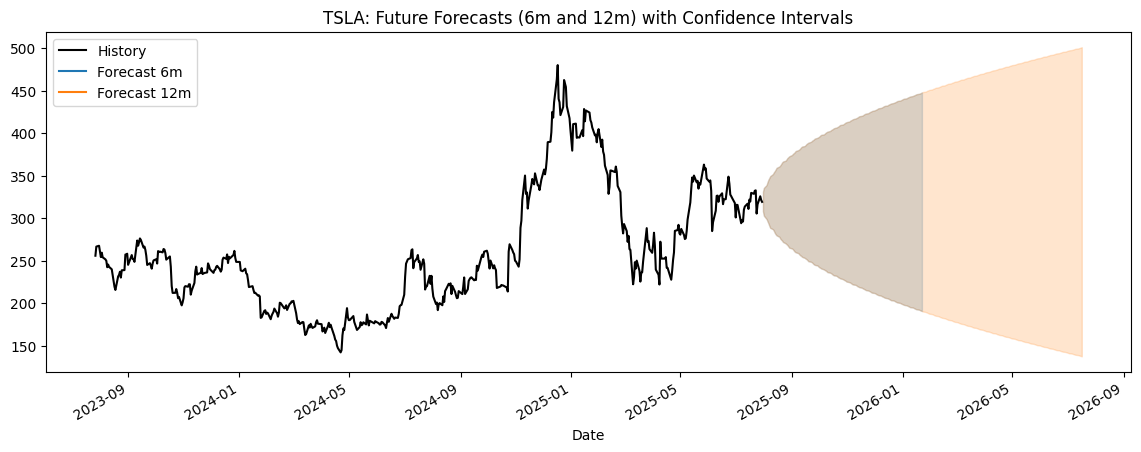

In [57]:
fig, ax = plt.subplots(figsize=(14,5))

# Plot history (last 2 years for focus)
history_tail = tsla_close.tail(504)
history_tail.plot(ax=ax, label='History', color='black')

# Plot 6-month forecast
fc_6m.mean.plot(ax=ax, label='Forecast 6m')
if fc_6m.lower is not None and fc_6m.upper is not None:
    ax.fill_between(fc_6m.mean.index, fc_6m.lower, fc_6m.upper, color='C0', alpha=0.2)

# Plot 12-month forecast
# Defensive: check that fc_12m and its mean are defined and not None before plotting
if 'fc_12m' in locals() and hasattr(fc_12m, 'mean') and fc_12m.mean is not None:
    fc_12m.mean.plot(ax=ax, label='Forecast 12m')
else:
    raise NameError("fc_12m or fc_12m.mean is not defined. Ensure forecast was run and returned a valid result.")
if fc_12m.lower is not None and fc_12m.upper is not None:
    ax.fill_between(fc_12m.mean.index, fc_12m.lower, fc_12m.upper, color='C1', alpha=0.2)

ax.set_title('TSLA: Future Forecasts (6m and 12m) with Confidence Intervals')
ax.legend();


### 4) Interpret the Results

- Trend Analysis: Discuss whether the central forecast suggests upward, downward, or stable movement.
- Patterns/Anomalies: Note any visible seasonality, mean-reversion, or outliers.
- Volatility and Risk: Examine the confidence intervals—do they widen with horizon? What does that say about uncertainty over longer forecasts?
- Market Opportunities/Risks: Identify potential opportunities (e.g., expected increases) and risks (e.g., high volatility, drawdowns).
